<a href="https://colab.research.google.com/github/ankita2002/LLMS/blob/main/HW4_Prompt_Optimization_wo_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Generative Automatic Prompt Optimization & Interpretability

This homework guides you through building an "Automatic Prompt Engineer" (APE) — a system where an LLM iteratively improves its own prompts based on error analysis. You will then use white-box interpretability techniques to understand *why* the optimized prompt works better.

**Total Points: 20**

## Learning Objectives

By completing this homework, you will:
- Understand how to build an automatic prompt optimization system using LLMs
- Learn to evaluate prompt performance systematically
- Gain experience with white-box interpretability techniques (attention patterns, confidence analysis)
- Analyze why certain prompts work better than others
- Practice error analysis and iterative improvement

## Expected Outcomes

After completing this homework, you should be able to:
1. Generate and evaluate prompts programmatically
2. Use meta-prompting to improve prompts iteratively
3. Extract and visualize attention patterns from transformer models
4. Analyze model confidence through logit analysis
5. Draw meaningful insights from interpretability tools

**Instructions:**
1. Complete all tasks in this notebook
2. Ensure your code runs without errors
3. Submit both this notebook and any additional files created
4. Write clear explanations for your approach
5. Fill in the `## YOUR_CODE_STARTS_HERE` / `## YOUR_CODE_ENDS_HERE` sections
6. Run the answer checkpoints after each task to verify your implementation


## Setup


In [1]:
# Install required packages
%pip install -q transformers torch datasets
%pip install -q matplotlib seaborn numpy


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import List, Dict, Tuple, Optional
import random
from collections import Counter
import re

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [7]:
# Using Gemma-2B-IT - better at arithmetic tasks than Phi-2
# If you prefer Phi-2, uncomment the alternative code below
print("Loading google/gemma-2b-it (excellent for math, supports output_attentions)...")
model_name = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Gemma needs pad_token set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16 if device.type == "cuda" else torch.float32,
    device_map="auto" if device.type == "cuda" else None,
    # Force eager attention for output_attentions support
    attn_implementation="eager"
)
if device.type == "cpu":
    model = model.to(device)
model.eval()
print("Model loaded successfully!")

Loading google/gemma-2b-it (excellent for math, supports output_attentions)...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Model loaded successfully!


## Dataset: Arithmetic Word Problems

We'll use a synthetic dataset of simple arithmetic word problems. This task is perfect for prompt optimization because:
1. Clear right/wrong answers (easy to evaluate)
2. The way you phrase the instruction matters a lot
3. Errors are interpretable (wrong numbers, wrong operations)


In [8]:
# Synthetic dataset of arithmetic word problems
def generate_arithmetic_dataset(n_samples: int = 100, seed: int = 42) -> List[Dict]:
    """Generate synthetic arithmetic word problems."""
    random.seed(seed)
    np.random.seed(seed)

    templates = [
        ("Alice has {a} apples. Bob gives her {b} more apples. How many apples does Alice have now?",
         lambda a, b: a + b),
        ("There are {a} birds on a tree. {b} birds fly away. How many birds are left?",
         lambda a, b: a - b),
        ("A store has {a} boxes. Each box contains {b} items. How many items are there in total?",
         lambda a, b: a * b),
        ("Tom has {a} candies. He wants to share them equally among {b} friends. How many candies does each friend get?",
         lambda a, b: a // b),
        ("{a} students are in a class. {b} more students join. What is the total number of students?",
         lambda a, b: a + b),
        ("A farmer has {a} cows. He sells {b} of them. How many cows does he have left?",
         lambda a, b: a - b),
    ]

    dataset = []
    for i in range(n_samples):
        template, operation = random.choice(templates)

        # Generate appropriate numbers based on operation
        if 'fly away' in template or 'sells' in template or 'left' in template:
            # Subtraction: ensure a >= b
            a = random.randint(10, 50)
            b = random.randint(1, a)
        elif 'share' in template or 'equally' in template:
            # Division: ensure clean division
            b = random.randint(2, 10)
            a = b * random.randint(2, 10)
        elif 'boxes' in template or 'contains' in template:
            # Multiplication: keep numbers small
            a = random.randint(2, 12)
            b = random.randint(2, 12)
        else:
            # Addition
            a = random.randint(5, 50)
            b = random.randint(5, 50)

        question = template.format(a=a, b=b)
        answer = str(operation(a, b))

        dataset.append({
            "question": question,
            "answer": answer
        })

    return dataset

# Generate dataset
full_dataset = generate_arithmetic_dataset(n_samples=120, seed=42)

# Split into train (for error analysis) and validation (for evaluation)
train_data = full_dataset[:60]
val_data = full_dataset[60:100]
test_data = full_dataset[100:]

print(f"Train set: {len(train_data)} examples")
print(f"Validation set: {len(val_data)} examples")
print(f"Test set: {len(test_data)} examples")
print("\nSample questions:")
for i in range(3):
    print(f"  Q: {train_data[i]['question']}")
    print(f"  A: {train_data[i]['answer']}\n")


Train set: 60 examples
Validation set: 40 examples
Test set: 20 examples

Sample questions:
  Q: A farmer has 17 cows. He sells 1 of them. How many cows does he have left?
  A: 16

  Q: A farmer has 27 cows. He sells 8 of them. How many cows does he have left?
  A: 19

  Q: There are 18 birds on a tree. 4 birds fly away. How many birds are left?
  A: 14



---

## TASK 1: The Evaluation Framework (5 points)

Build the infrastructure to evaluate how well a prompt performs on our arithmetic task.

**1.1**: *Generate Response* — Implement a function to generate model responses given a prompt template  
**1.2**: *Evaluate Prompt* — Implement evaluation that returns accuracy and failed cases  
**1.3**: *Baseline Testing* — Establish baseline performance with a naive prompt


### Task 1.1: Generate Response Function

**Goal**: Implement a function that generates model responses given a prompt template and question.

**Requirements**:

- Format the prompt template by inserting the question into the `{question}` placeholder
- Tokenize the formatted prompt and prepare it for the model (move to correct device)
- Generate a response using the model with greedy decoding (deterministic)
- Extract only the newly generated tokens (not the input prompt tokens)
- Decode the generated tokens back to text
- Return a dictionary with at least a `'response'` key containing the generated text
- Optionally include `'logits'` and `'attentions'` in the dictionary if requested via function parameters

**Important considerations**:
- For decoder-only models, `outputs.sequences` contains both input and generated tokens - you need to extract only the new tokens
- Handle `pad_token_id` appropriately (use `eos_token_id` if `pad_token_id` is None)
- Clean up the response text (strip whitespace, handle newlines appropriately)

**Expected return format**: A dictionary with at least `{'response': str}`. The response should be a non-empty string containing the model's generated text.

**Success criteria**:
- Function returns a dictionary
- Dictionary contains a `'response'` key with a non-empty string
- For arithmetic problems, the response should ideally contain a number


In [9]:
def generate_response(
    model,
    tokenizer,
    prompt_template: str,
    question: str,
    max_new_tokens: int = 200,  # Reduced for arithmetic (just need a number)
    return_logits: bool = False,
    return_attentions: bool = False
) -> Dict:
    """
    Generate a response from the model given a prompt template and question.

    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt_template: A string with {question} placeholder (e.g., "Solve: {question}")
        question: The actual question to insert
        max_new_tokens: Maximum tokens to generate
        return_logits: Whether to return the logits
        return_attentions: Whether to return attention weights

    Returns:
        Dictionary with 'response' (str), and optionally 'logits' and 'attentions'
    """
    ## YOUR_CODE_STARTS_HERE

    prompt = prompt_template.format(question=question)
    inputs = tokenizer(prompt, return_tensors="pt")
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    input_len = inputs["input_ids"].shape[1]

    pad_token_id = tokenizer.pad_token_id
    if pad_token_id is None:
        pad_token_id = tokenizer.eos_token_id

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=pad_token_id,
            output_logits=return_logits,
            output_attentions=return_attentions,
            return_dict_in_generate=True
        )

    generated_ids = outputs.sequences[:, input_len:]

    response_text = tokenizer.decode(
        generated_ids[0],
        skip_special_tokens=True
    ).strip()

    result = {"response": response_text}

    if return_logits:
        result["logits"] = outputs.logits

    if return_attentions:
        result["attentions"] = outputs.attentions

    return result
    ## YOUR_CODE_ENDS_HERE


In [10]:
# Test the generate_response function
test_prompt = "Answer the math question: {question}"
test_question = "Alice has 5 apples. Bob gives her 3 more apples. How many apples does Alice have now?"

result = generate_response(model, tokenizer, test_prompt, test_question)
print(f"Prompt template: {test_prompt}")
print(f"Question: {test_question}")
print(f"Response: {result['response']}")
## RESULT_CHECKING_POINT -> Should output a number (ideally '8')


Prompt template: Answer the math question: {question}
Question: Alice has 5 apples. Bob gives her 3 more apples. How many apples does Alice have now?
Response: Alice starts with 5 apples, and Bob gives her 3 more apples, so she ends up with 5 + 3 = 8 apples.

Therefore, Alice has 8 apples now.


In [11]:
# Answer Checkpoint: Task 1.1 - Generate Response
print("="*70)
print("VALIDATING: generate_response function")
print("="*70)

checks_passed = 0
checks_failed = 0

# Test 1: Function returns dictionary
try:
    test_result = generate_response(model, tokenizer, "Test: {question}", "What is 2+2?")
    if isinstance(test_result, dict):
        print("✓ PASS: Function returns dictionary")
        checks_passed += 1
    else:
        print(f"✗ FAIL: Function should return a dictionary, got {type(test_result)}")
        checks_failed += 1
except Exception as e:
    print(f"✗ FAIL: Function raised an error: {e}")
    checks_failed += 1
    test_result = None

# Test 2: Dictionary has 'response' key
if test_result is not None:
    try:
        if 'response' in test_result:
            print("✓ PASS: Dictionary contains 'response' key")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Dictionary should contain 'response' key. Keys found: {list(test_result.keys())}")
            checks_failed += 1
    except Exception as e:
        print(f"✗ FAIL: Error checking 'response' key: {e}")
        checks_failed += 1

# Test 3: Response is non-empty string
if test_result is not None and 'response' in test_result:
    try:
        response = test_result['response']
        if isinstance(response, str) and len(response) > 0:
            print("✓ PASS: Response is a non-empty string")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Response should be a non-empty string. Got: {type(response)}, length: {len(response) if isinstance(response, str) else 'N/A'}")
            checks_failed += 1
    except Exception as e:
        print(f"✗ FAIL: Error checking response type: {e}")
        checks_failed += 1

# Test 4: Response contains a number (for arithmetic problems)
if test_result is not None and 'response' in test_result:
    try:
        response = test_result['response']
        import re
        has_number = bool(re.search(r'\d+', response))
        if has_number:
            print("✓ PASS: Response contains a number")
            checks_passed += 1
        else:
            print("⚠ WARNING: Response doesn't contain a number - this might be okay for some prompts")
            print(f"   Response was: '{response[:100]}...'")
    except Exception as e:
        print(f"⚠ WARNING: Could not check for numbers: {e}")

# Test 5: Test with the actual test case from the notebook
try:
    test_prompt = "Answer the math question: {question}"
    test_question = "Alice has 5 apples. Bob gives her 3 more apples. How many apples does Alice have now?"
    result = generate_response(model, tokenizer, test_prompt, test_question)
    if isinstance(result, dict) and 'response' in result:
        print("✓ PASS: Function works with test case from notebook")
        checks_passed += 1
        # Check if response contains the expected answer (8)
        response = result['response']
        if '8' in response or 'eight' in response.lower():
            print("✓ PASS: Response contains expected answer (8)")
            checks_passed += 1
        else:
            print(f"⚠ INFO: Response doesn't clearly contain '8', but this may vary by model")
            print(f"   Response: '{response[:100]}...'")
    else:
        print("✗ FAIL: Function doesn't work with test case")
        checks_failed += 1
except Exception as e:
    print(f"✗ FAIL: Error with test case: {e}")
    checks_failed += 1

print("\n" + "="*70)
if checks_failed == 0:
    print(f"All checks passed! ✓ ({checks_passed} checks)")
else:
    print(f"Some checks failed: {checks_passed} passed, {checks_failed} failed")
    print("Please review your implementation and try again.")
print("="*70)


VALIDATING: generate_response function
✓ PASS: Function returns dictionary
✓ PASS: Dictionary contains 'response' key
✓ PASS: Response is a non-empty string
✓ PASS: Response contains a number
✓ PASS: Function works with test case from notebook
✓ PASS: Response contains expected answer (8)

All checks passed! ✓ (6 checks)


### Task 1.2: Evaluate Prompt Function

**Goal**: Implement functions to extract numbers from text and evaluate prompt performance on a dataset.

#### Part A: `extract_number` function

Extract the first numeric answer from a text response. The model might respond in various formats (e.g., `"8"`, `"The answer is 8"`, `"8 apples"`, `"Alice has 8 apples"`). The function should handle these cases and return the first number found as a string, or `None` if no number is present.

**Expected return**: A string containing the number (e.g., `"8"`) or `None` if no number found.

#### Part B: `evaluate_prompt` function

Evaluate how well a prompt performs on a dataset by:
- Running the prompt on each example using `generate_response()`
- Extracting the predicted number from each response using `extract_number()`
- Comparing predictions to target answers (exact string match)
- Calculating accuracy as `correct_predictions / total_examples`
- Collecting failed cases with information about each error

**Expected return format**: A tuple `(float, List[Dict])` where:
- First element is accuracy (0.0 to 1.0)
- Second element is a list of dictionaries, each containing failed case information with keys: `'question'`, `'prediction'`, `'target'`, `'raw_response'`

**Success criteria**:
- `extract_number` handles various text formats correctly
- `evaluate_prompt` returns a tuple of (float, list)
- Accuracy is between 0.0 and 1.0
- Failed cases list contains dictionaries with the required keys


In [12]:
def extract_number(text: str) -> Optional[str]:
    """
    Extract the first number from a text response.
    Handles cases like '8', 'The answer is 8', '8 apples', etc.
    """
    # Clean up text - remove special characters that might confuse extraction
    text = text.strip()

    # Remove common prefixes
    prefixes = ["Answer:", "The answer is", "Answer is", "The answer:", "Result:", "Result is"]
    for prefix in prefixes:
        if text.lower().startswith(prefix.lower()):
            text = text[len(prefix):].strip()

    # Find all numbers in the text
    numbers = re.findall(r'-?\d+', text)
    if numbers:
        # Return the first number that looks like an answer (not too large, positive for our problems)
        for num in numbers:
            num_int = int(num)
            # For arithmetic word problems, answers are typically reasonable positive numbers
            if 0 <= num_int <= 10000:  # Reasonable range for our problems
                return num
        # If no reasonable number found, return first number anyway
        return numbers[0]
    return None

def evaluate_prompt(
    model,
    tokenizer,
    prompt_template: str,
    dataset: List[Dict],
    verbose: bool = False
) -> Tuple[float, List[Dict]]:
    """
    Evaluate a prompt template on a dataset.

    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt_template: Template with {question} placeholder
        dataset: List of {'question': str, 'answer': str} dicts
        verbose: Whether to print progress

    Returns:
        Tuple of (accuracy: float, failed_cases: List[Dict])
        failed_cases contains {'question', 'prediction', 'target'} for each error
    """
    ## YOUR_CODE_STARTS_HERE
    correct = 0
    failed_cases = []

    total = len(dataset)

    for idx, example in enumerate(dataset):
        question = example["question"]
        target = str(example["answer"])

        result = generate_response(
            model=model,
            tokenizer=tokenizer,
            prompt_template=prompt_template,
            question=question
        )

        raw_response = result["response"]
        prediction = extract_number(raw_response)

        if prediction == target:
            correct += 1
        else:
            failed_cases.append({
                "question": question,
                "prediction": prediction,
                "target": target,
                "raw_response": raw_response
            })

        if verbose:
            print(f"[{idx+1}/{total}] Q: {question}")
            print(f"  Target: {target}")
            print(f"  Raw: {raw_response}")
            print(f"  Pred: {prediction}\n")

    accuracy = correct / total if total > 0 else 0.0

    ## YOUR_CODE_ENDS_HERE

    return accuracy, failed_cases


In [13]:
# Test the evaluate_prompt function on a small subset
test_prompt = "{question}"
accuracy, failures = evaluate_prompt(model, tokenizer, test_prompt, val_data[:10], verbose=True)
print(f"\nAccuracy: {accuracy:.2%}")
print(f"Number of failures: {len(failures)}")
if failures:
    print(f"\nSample failure:")
    print(f"  Question: {failures[0]['question']}")
    print(f"  Predicted: {failures[0]['prediction']}")
    print(f"  Target: {failures[0]['target']}")


[1/10] Q: Tom has 6 candies. He wants to share them equally among 2 friends. How many candies does each friend get?
  Target: 3
  Raw: To share the candies equally, Tom needs to distribute 6 candies equally between 2 friends. Each friend will receive 3 candies.
  Pred: 6

[2/10] Q: A store has 6 boxes. Each box contains 5 items. How many items are there in total?
  Target: 30
  Raw: There are 6 boxes * 5 items/box = 30 items in total.
  Pred: 6

[3/10] Q: Alice has 20 apples. Bob gives her 41 more apples. How many apples does Alice have now?
  Target: 61
  Raw: Alice started with 20 apples, and Bob gave her 41 more apples, so she ended up with 20 + 41 = 61 apples.

Therefore, Alice has 61 apples now.
  Pred: 20

[4/10] Q: Alice has 10 apples. Bob gives her 36 more apples. How many apples does Alice have now?
  Target: 46
  Raw: Alice started with 10 apples, and Bob gave her 36 more apples, so she ended up with 10 + 36 = 46 apples.

Therefore, Alice has 46 apples now.
  Pred: 10

[5/10]

In [14]:
# Answer Checkpoint: Task 1.2 - Evaluate Prompt
print("="*70)
print("VALIDATING: extract_number and evaluate_prompt functions")
print("="*70)

checks_passed = 0
checks_failed = 0

# Test 1: extract_number handles various formats
test_cases = [
    ("8", "8"),
    ("The answer is 8", "8"),
    ("8 apples", "8"),
    ("Alice has 8 apples", "8"),
    ("Result: 42", "42"),
    ("No number here", None),
    ("", None),
]

print("\nTesting extract_number function:")
for text, expected in test_cases:
    try:
        result = extract_number(text)
        if result == expected:
            print(f"✓ PASS: extract_number('{text[:30]}...') = {result}")
            checks_passed += 1
        else:
            print(f"✗ FAIL: extract_number('{text[:30]}...') = {result}, expected {expected}")
            checks_failed += 1
    except Exception as e:
        print(f"✗ FAIL: extract_number('{text[:30]}...') raised error: {e}")
        checks_failed += 1

# Test 2: evaluate_prompt returns tuple
print("\nTesting evaluate_prompt function:")
try:
    test_prompt = "{question}\nAnswer:"
    accuracy, failures = evaluate_prompt(model, tokenizer, test_prompt, val_data[:5], verbose=False)

    # Check return type
    if isinstance(accuracy, (int, float)) and isinstance(failures, list):
        print("✓ PASS: evaluate_prompt returns tuple of (number, list)")
        checks_passed += 1
    else:
        print(f"✗ FAIL: evaluate_prompt should return (float, list), got ({type(accuracy)}, {type(failures)})")
        checks_failed += 1

    # Check accuracy range
    if 0.0 <= accuracy <= 1.0:
        print(f"✓ PASS: Accuracy is in valid range [0.0, 1.0]: {accuracy:.2%}")
        checks_passed += 1
    else:
        print(f"✗ FAIL: Accuracy should be between 0.0 and 1.0, got {accuracy}")
        checks_failed += 1

    # Check failed cases structure
    if len(failures) > 0:
        first_failure = failures[0]
        required_keys = ['question', 'prediction', 'target', 'raw_response']
        if all(key in first_failure for key in required_keys):
            print("✓ PASS: Failed cases have correct structure")
            checks_passed += 1
        else:
            missing = [k for k in required_keys if k not in first_failure]
            print(f"✗ FAIL: Failed cases missing keys: {missing}")
            checks_failed += 1
    else:
        print("⚠ INFO: No failures found (this is okay if accuracy is 100%)")
        checks_passed += 1

except Exception as e:
    print(f"✗ FAIL: evaluate_prompt raised error: {e}")
    checks_failed += 1

print("\n" + "="*70)
if checks_failed == 0:
    print(f"All checks passed! ✓ ({checks_passed} checks)")
else:
    print(f"Some checks failed: {checks_passed} passed, {checks_failed} failed")
    print("Please review your implementation and try again.")
print("="*70)


VALIDATING: extract_number and evaluate_prompt functions

Testing extract_number function:
✓ PASS: extract_number('8...') = 8
✓ PASS: extract_number('The answer is 8...') = 8
✓ PASS: extract_number('8 apples...') = 8
✓ PASS: extract_number('Alice has 8 apples...') = 8
✓ PASS: extract_number('Result: 42...') = 42
✓ PASS: extract_number('No number here...') = None
✓ PASS: extract_number('...') = None

Testing evaluate_prompt function:
✓ PASS: evaluate_prompt returns tuple of (number, list)
✓ PASS: Accuracy is in valid range [0.0, 1.0]: 60.00%
✓ PASS: Failed cases have correct structure

All checks passed! ✓ (10 checks)


### Task 1.3: Baseline Evaluation

**Goal**: Test multiple baseline prompts to establish a starting point for optimization.

**Requirements**:

- Define a list of simple, naive prompt templates to test (at least 3-5 prompts)
- Evaluate each prompt on the validation set using `evaluate_prompt()`
- Store results (accuracy and failures) for each prompt in a dictionary
- Select the prompt with the highest accuracy as the starting point for optimization

**What to look for**:
- Different prompts will have different accuracies
- The best baseline gives us a reference point - we want to improve upon it
- Typical baseline accuracies for arithmetic problems: 20-60% (varies by model and prompt quality)

**Success criteria**:
- At least 3-5 baseline prompts tested
- Best baseline accuracy > 0% (model is working)
- Results dictionary structure is correct with 'accuracy' and 'failures' keys
- Best baseline prompt selected and stored


In [15]:
# Define several baseline prompts to test (intentionally weak to show optimization improvement)
baseline_prompts = [
    "{question}",  # Just the question, no instruction
    "{question}?",  # Just question mark
    "Here: {question}",  # Ambiguous
    "{question} answer",  # Unclear format
    "Math: {question}",  # Minimal context
]

print("Evaluating baseline prompts on validation set...\n")
print("=" * 70)

baseline_results = {}
for prompt in baseline_prompts:
    accuracy, failures = evaluate_prompt(model, tokenizer, prompt, val_data)
    baseline_results[prompt] = {'accuracy': accuracy, 'failures': failures}
    print(f"Prompt: '{prompt[:50]}...'" if len(prompt) > 50 else f"Prompt: '{prompt}'")
    print(f"Accuracy: {accuracy:.2%} ({int(accuracy * len(val_data))}/{len(val_data)})")
    print("-" * 70)

# Select the best baseline as our starting point
best_baseline_prompt = max(baseline_results.keys(), key=lambda p: baseline_results[p]['accuracy'])
best_baseline_accuracy = baseline_results[best_baseline_prompt]['accuracy']
best_baseline_failures = baseline_results[best_baseline_prompt]['failures']

print(f"\nBest baseline prompt: '{best_baseline_prompt}'")
print(f"Best baseline accuracy: {best_baseline_accuracy:.2%}")


Evaluating baseline prompts on validation set...

Prompt: '{question}'
Accuracy: 5.00% (2/40)
----------------------------------------------------------------------
Prompt: '{question}?'
Accuracy: 7.50% (3/40)
----------------------------------------------------------------------
Prompt: 'Here: {question}'
Accuracy: 5.00% (2/40)
----------------------------------------------------------------------
Prompt: '{question} answer'
Accuracy: 70.00% (28/40)
----------------------------------------------------------------------
Prompt: 'Math: {question}'
Accuracy: 0.00% (0/40)
----------------------------------------------------------------------

Best baseline prompt: '{question} answer'
Best baseline accuracy: 70.00%


In [16]:
# Answer Checkpoint: Task 1.3 - Baseline Evaluation
print("="*70)
print("VALIDATING: Baseline evaluation results")
print("="*70)

checks_passed = 0
checks_failed = 0

# Check if baseline_results exists and has correct structure
try:
    if 'baseline_results' in globals():
        print("✓ PASS: baseline_results variable exists")
        checks_passed += 1

        # Check that at least 3 prompts were tested
        if len(baseline_results) >= 3:
            print(f"✓ PASS: At least 3 baseline prompts tested ({len(baseline_results)} prompts)")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Should test at least 3 prompts, found {len(baseline_results)}")
            checks_failed += 1

        # Check structure of results
        for prompt, result in baseline_results.items():
            if isinstance(result, dict) and 'accuracy' in result and 'failures' in result:
                checks_passed += 1
                break
            else:
                print(f"✗ FAIL: baseline_results should contain dicts with 'accuracy' and 'failures' keys")
                checks_failed += 1
                break

        # Check best baseline variables
        if 'best_baseline_prompt' in globals() and 'best_baseline_accuracy' in globals():
            print("✓ PASS: best_baseline_prompt and best_baseline_accuracy variables exist")
            checks_passed += 1

            # Check accuracy is valid
            if isinstance(best_baseline_accuracy, (int, float)) and 0.0 <= best_baseline_accuracy <= 1.0:
                print(f"✓ PASS: Best baseline accuracy is valid: {best_baseline_accuracy:.2%}")
                checks_passed += 1

                if best_baseline_accuracy > 0:
                    print("✓ PASS: Best baseline accuracy > 0% (model is working)")
                    checks_passed += 1
                else:
                    print("⚠ WARNING: Best baseline accuracy is 0% - model may not be working correctly")
            else:
                print(f"✗ FAIL: best_baseline_accuracy should be between 0.0 and 1.0, got {best_baseline_accuracy}")
                checks_failed += 1
        else:
            print("✗ FAIL: best_baseline_prompt and/or best_baseline_accuracy not defined")
            checks_failed += 1
    else:
        print("✗ FAIL: baseline_results variable not found. Did you run the baseline evaluation cell?")
        checks_failed += 1
except Exception as e:
    print(f"✗ FAIL: Error checking baseline results: {e}")
    checks_failed += 1

print("\n" + "="*70)
if checks_failed == 0:
    print(f"All checks passed! ✓ ({checks_passed} checks)")
else:
    print(f"Some checks failed: {checks_passed} passed, {checks_failed} failed")
    print("Please review your implementation and try again.")
print("="*70)


VALIDATING: Baseline evaluation results
✓ PASS: baseline_results variable exists
✓ PASS: At least 3 baseline prompts tested (5 prompts)
✓ PASS: best_baseline_prompt and best_baseline_accuracy variables exist
✓ PASS: Best baseline accuracy is valid: 70.00%
✓ PASS: Best baseline accuracy > 0% (model is working)

All checks passed! ✓ (6 checks)


---

## TASK 2: Generative Optimization Loop (7 points)

Now we'll build the core APE system: a feedback loop where the model analyzes its errors and generates improved prompts.

**2.1**: *Error Analysis Prompt* — Construct a meta-prompt that shows the model its failures  
**2.2**: *Candidate Generation* — Generate multiple candidate prompts  
**2.3**: *Optimization Loop* — Implement the full iterative optimization cycle


### Task 2.1: Error Analysis Meta-Prompt

**Goal**: Create a "meta-prompt" that instructs the model to analyze its errors and suggest an improved prompt.

**What is a meta-prompt?**
A meta-prompt is a prompt that asks the model to generate another prompt. We'll show the model its failures and ask it to write a better instruction prompt.

**Requirements**:

- Randomly sample `n_examples` from the `failed_cases` list
- Format each failed case to show: the question, the model's prediction, and the correct answer
- Construct a meta-prompt string that:
  - Explains the context (using an AI to solve math word problems)
  - Shows the current prompt being used
  - Presents the failed examples in a clear format
  - Asks the model to write a better prompt
  - **Important**: Emphasize that the new prompt MUST contain `{question}` as a placeholder
  - Instruct the model to output ONLY the new prompt, nothing else

**Example meta-prompt structure**:
```
I am using an AI to solve math word problems. The current instruction prompt is:

"{current_prompt}"

However, the AI made mistakes on these examples:
Example 1:
  Question: [question]
  Model predicted: [prediction]
  Correct answer: [target]
...

Write a better instruction prompt that would help the AI answer correctly.
The prompt must contain {question} as a placeholder.
Output only the new prompt, nothing else.

New prompt:
```

**Success criteria**:
- Meta-prompt contains the current prompt
- Meta-prompt contains at least one failed example
- Meta-prompt asks for an improved prompt
- Meta-prompt explicitly mentions the `{question}` placeholder requirement


In [18]:
def create_meta_prompt(
    current_prompt: str,
    failed_cases: List[Dict],
    n_examples: int = 3
) -> str:
    """
    Create a meta-prompt for the model to analyze errors and suggest a better prompt.

    Args:
        current_prompt: The prompt template currently being used
        failed_cases: List of failed examples with 'question', 'prediction', 'target'
        n_examples: Number of failed examples to include

    Returns:
        A meta-prompt string asking the model to improve the prompt
    """
    ## YOUR_CODE_STARTS_HERE
    if not failed_cases:
        raise ValueError("failed_cases must contain at least one example")

    sample_size = min(n_examples, len(failed_cases))
    examples = random.sample(failed_cases, sample_size)

    formatted_examples = []
    for i, case in enumerate(examples, start=1):
        formatted_examples.append(
            f"Example {i}:\n"
            f"  Question: {case['question']}\n"
            f"  Model predicted: {case['prediction']}\n"
            f"  Correct answer: {case['target']}"
        )

    examples_block = "\n\n".join(formatted_examples)

    meta_prompt = (
        "I am using an AI to solve math word problems. "
        "The AI is given an instruction prompt and a question, "
        "and it must produce the correct numeric answer.\n\n"
        f"The current instruction prompt is:\n\n"
        f"\"{current_prompt}\"\n\n"
        "However, the AI made mistakes on the following examples:\n\n"
        f"{examples_block}\n\n"
        "Write a better instruction prompt that would help the AI answer these types "
        "of math word problems correctly.\n\n"
        "IMPORTANT:\n"
        "- The new prompt MUST contain the placeholder {question}\n"
        "- The prompt should encourage correct reasoning and a final numeric answer\n"
        "- Output ONLY the new prompt text, and nothing else\n\n"
        "New prompt:"
    )

    return meta_prompt

    ## YOUR_CODE_ENDS_HERE


In [19]:
# Answer Checkpoint: Task 2.1 - Meta-Prompt Creation
print("="*70)
print("VALIDATING: create_meta_prompt function")
print("="*70)

checks_passed = 0
checks_failed = 0

try:
    # Test with sample data
    if 'best_baseline_prompt' in globals() and 'best_baseline_failures' in globals():
        test_meta = create_meta_prompt(best_baseline_prompt, best_baseline_failures[:5], n_examples=2)

        # Check 1: Returns a string
        if isinstance(test_meta, str):
            print("✓ PASS: Function returns a string")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Function should return string, got {type(test_meta)}")
            checks_failed += 1

        # Check 2: Contains current prompt
        if best_baseline_prompt in test_meta or best_baseline_prompt.replace('\n', ' ') in test_meta:
            print("✓ PASS: Meta-prompt contains current prompt")
            checks_passed += 1
        else:
            print("✗ FAIL: Meta-prompt should contain the current prompt")
            checks_failed += 1

        # Check 3: Contains failed examples
        if len(best_baseline_failures) > 0:
            first_failure_q = best_baseline_failures[0].get('question', '')
            if first_failure_q and first_failure_q in test_meta:
                print("✓ PASS: Meta-prompt contains failed examples")
                checks_passed += 1
            else:
                print("⚠ WARNING: Meta-prompt may not contain failed examples")

        # Check 4: Mentions {question} placeholder requirement
        if '{question}' in test_meta or 'question' in test_meta.lower():
            print("✓ PASS: Meta-prompt mentions question placeholder")
            checks_passed += 1
        else:
            print("⚠ WARNING: Meta-prompt should mention {question} placeholder requirement")

        # Check 5: Asks for improved prompt
        if any(word in test_meta.lower() for word in ['better', 'improve', 'new prompt', 'write']):
            print("✓ PASS: Meta-prompt asks for improved prompt")
            checks_passed += 1
        else:
            print("⚠ WARNING: Meta-prompt should ask for an improved prompt")
    else:
        print("⚠ SKIP: best_baseline_prompt or best_baseline_failures not found. Run Task 1.3 first.")
except Exception as e:
    print(f"✗ FAIL: Error testing create_meta_prompt: {e}")
    checks_failed += 1

print("\n" + "="*70)
if checks_failed == 0:
    print(f"All checks passed! ✓ ({checks_passed} checks)")
else:
    print(f"Some checks failed: {checks_passed} passed, {checks_failed} failed")
print("="*70)


VALIDATING: create_meta_prompt function
✓ PASS: Function returns a string
✓ PASS: Meta-prompt contains current prompt
⚠ WARNING: Meta-prompt may not contain failed examples
✓ PASS: Meta-prompt mentions question placeholder
✓ PASS: Meta-prompt asks for improved prompt

All checks passed! ✓ (4 checks)


In [20]:
# Test the meta-prompt creation
sample_meta_prompt = create_meta_prompt(best_baseline_prompt, best_baseline_failures, n_examples=2)
print("Sample Meta-Prompt:")
print("=" * 70)
print(sample_meta_prompt)
print("=" * 70)


Sample Meta-Prompt:
I am using an AI to solve math word problems. The AI is given an instruction prompt and a question, and it must produce the correct numeric answer.

The current instruction prompt is:

"{question} answer"

However, the AI made mistakes on the following examples:

Example 1:
  Question: There are 46 birds on a tree. 37 birds fly away. How many birds are left?
  Model predicted: 19
  Correct answer: 9

Example 2:
  Question: A farmer has 33 cows. He sells 29 of them. How many cows does he have left?
  Model predicted: 33
  Correct answer: 4

Write a better instruction prompt that would help the AI answer these types of math word problems correctly.

IMPORTANT:
- The new prompt MUST contain the placeholder {question}
- The prompt should encourage correct reasoning and a final numeric answer
- Output ONLY the new prompt text, and nothing else

New prompt:


### Task 2.2: Candidate Prompt Generation

**Goal**: Generate multiple diverse candidate prompts from the meta-prompt using sampling.

**Step-by-step instructions**:

1. **Tokenize the meta-prompt**: Convert the meta-prompt string to token IDs, similar to `generate_response()`

2. **Generate multiple candidates**: Loop to generate `n_candidates` valid prompts:
   - Use `model.generate()` with `do_sample=True` for diversity
   - Set `temperature` (e.g., 0.7) - higher = more diverse, lower = more focused
   - Use `top_p=0.9` for nucleus sampling (helps with quality)
   - Generate extra candidates (e.g., `n_candidates * 5`) since some may be invalid

3. **Clean and normalize candidates**:
   - Decode only the newly generated tokens (not the input)
   - Strip whitespace
   - Remove surrounding quotes if present (`"..."` or `'...'`)
   - Normalize placeholder: replace variations like `{example_question}` or `{the_question}` with `{question}`
   - If candidate mentions "question" but has no placeholder, try to add `{question}`

4. **Validate candidates**:
   - Must contain `{question}` placeholder
   - Must be reasonable length (< 200 characters)
   - Must be able to be formatted: `candidate.format(question="test")` should work
   - Should not be duplicate of existing candidates
   - Should be meaningfully different from current prompt (optional but helpful)

5. **Return valid candidates**: Return up to `n_candidates` valid prompts

**Key parameters**:
- `temperature`: Controls randomness (0.7-0.9 good for diversity)
- `top_p`: Nucleus sampling threshold (0.9 is standard)
- `max_new_tokens`: Limit generation length (150-200 tokens recommended for complete prompts)

**Success criteria**:
- Function returns a list of strings
- All candidates contain `{question}` placeholder
- All candidates can be formatted without KeyError
- At least 1 candidate generated (even if fewer than requested)


In [22]:
def generate_candidate_prompts(
    model,
    tokenizer,
    meta_prompt: str,
    n_candidates: int = 5,
    temperature: float = 0.7
) -> List[str]:
    """
    Generate multiple candidate prompts using the meta-prompt.

    Args:
        model: The language model
        tokenizer: The tokenizer
        meta_prompt: The meta-prompt asking for improved prompts
        n_candidates: Number of candidates to generate
        temperature: Sampling temperature for diversity

    Returns:
        List of valid candidate prompt strings (containing {question})
    """
    ## YOUR_CODE_STARTS_HERE
    device = model.device

    inputs = tokenizer(meta_prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    input_len = inputs["input_ids"].shape[1]

    pad_token_id = tokenizer.pad_token_id
    if pad_token_id is None:
        pad_token_id = tokenizer.eos_token_id

    valid_candidates = []
    seen = set()

    max_attempts = n_candidates * 5

    for _ in range(max_attempts):
        if len(valid_candidates) >= n_candidates:
            break

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                max_new_tokens=150,
                pad_token_id=pad_token_id,
                return_dict_in_generate=True
            )

        gen_ids = outputs.sequences[:, input_len:]
        text = tokenizer.decode(gen_ids[0], skip_special_tokens=True).strip()

        if not text:
            continue

        # Remove surrounding quotes
        if (text.startswith('"') and text.endswith('"')) or (
            text.startswith("'") and text.endswith("'")
        ):
            text = text[1:-1].strip()
        text = re.sub(r"\{[^}]*question[^}]*\}", "{question}", text, flags=re.IGNORECASE)

        if "{question}" not in text and "question" in text.lower():
            text = text.rstrip(".") + " {question}"

        # Validation checks
        if "{question}" not in text:
            continue

        if len(text) > 200:
            continue

        try:
            # Must be safely formattable
            text.format(question="test")
        except Exception:
            continue

        if text in seen:
            continue

        seen.add(text)
        valid_candidates.append(text)

    return valid_candidates

    ## YOUR_CODE_ENDS_HERE


In [23]:
# Answer Checkpoint: Task 2.2 - Candidate Generation
print("="*70)
print("VALIDATING: generate_candidate_prompts function")
print("="*70)

checks_passed = 0
checks_failed = 0

try:
    if 'sample_meta_prompt' in globals():
        test_candidates = generate_candidate_prompts(model, tokenizer, sample_meta_prompt, n_candidates=3, temperature=0.7)

        # Check 1: Returns a list
        if isinstance(test_candidates, list):
            print("✓ PASS: Function returns a list")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Function should return list, got {type(test_candidates)}")
            checks_failed += 1

        # Check 2: All items are strings
        if all(isinstance(c, str) for c in test_candidates):
            print("✓ PASS: All candidates are strings")
            checks_passed += 1
        else:
            print("✗ FAIL: All candidates should be strings")
            checks_failed += 1

        # Check 3: All contain {question}
        if len(test_candidates) > 0:
            all_have_placeholder = all('{question}' in c for c in test_candidates)
            if all_have_placeholder:
                print("✓ PASS: All candidates contain {question} placeholder")
                checks_passed += 1
            else:
                missing = [i for i, c in enumerate(test_candidates) if '{question}' not in c]
                print(f"✗ FAIL: Candidates {missing} missing {{question}} placeholder")
                checks_failed += 1

            # Check 4: All can be formatted
            format_errors = []
            for i, c in enumerate(test_candidates):
                try:
                    c.format(question="test")
                except KeyError as e:
                    format_errors.append(i)

            if len(format_errors) == 0:
                print("✓ PASS: All candidates can be formatted")
                checks_passed += 1
            else:
                print(f"✗ FAIL: Candidates {format_errors} cannot be formatted (KeyError)")
                checks_failed += 1

            # Check 5: At least 1 candidate
            if len(test_candidates) >= 1:
                print(f"✓ PASS: Generated at least 1 candidate ({len(test_candidates)} candidates)")
                checks_passed += 1
            else:
                print("⚠ WARNING: No candidates generated (this may be okay if model is struggling)")
        else:
            print("⚠ WARNING: No candidates generated")
    else:
        print("⚠ SKIP: sample_meta_prompt not found. Run Task 2.1 test cell first.")
except Exception as e:
    print(f"✗ FAIL: Error testing generate_candidate_prompts: {e}")
    import traceback
    traceback.print_exc()
    checks_failed += 1

print("\n" + "="*70)
if checks_failed == 0:
    print(f"All checks passed! ✓ ({checks_passed} checks)")
else:
    print(f"Some checks failed: {checks_passed} passed, {checks_failed} failed")
print("="*70)


VALIDATING: generate_candidate_prompts function
✓ PASS: Function returns a list
✓ PASS: All candidates are strings
✓ PASS: All candidates contain {question} placeholder
✓ PASS: All candidates can be formatted
✓ PASS: Generated at least 1 candidate (2 candidates)

All checks passed! ✓ (5 checks)


In [24]:
# Test candidate generation
print("Generating candidate prompts...")
candidates = generate_candidate_prompts(model, tokenizer, sample_meta_prompt, n_candidates=3)
print(f"\nGenerated {len(candidates)} valid candidates:")
for i, c in enumerate(candidates, 1):
    print(f"  {i}. {c}")


Generating candidate prompts...

Generated 3 valid candidates:
  1. Give the answer to the question using the following reasoning: {question}
  2. {question} = ?
  3. Give the answer to the following math word problem using the following reasoning: {question}


### Task 2.3: The Full Optimization Loop

**Goal**: Implement the complete Automatic Prompt Engineering (APE) algorithm that iteratively improves prompts.

**Algorithm Overview**:

The APE algorithm follows this iterative process:
1. **Evaluate** current prompt on training and validation data
2. **Analyze** errors to understand failure modes
3. **Generate** candidate improved prompts using meta-prompting
4. **Evaluate** candidates on validation data
5. **Select** best candidate (if better than current)
6. **Repeat** until convergence or max iterations

**Requirements**:

- **Initialize history**: Create a dictionary to track iterations, prompts tried, accuracies, best prompt, and best accuracy

- **Main optimization loop** (for each iteration):
  - Evaluate current prompt on both training data (for error analysis) and validation data (for selection)
  - Update history with current iteration results
  - Check stopping conditions (target accuracy reached, no failures, max iterations, no valid candidates)
  - Generate candidate prompts using meta-prompting from training failures
  - Evaluate all candidates on validation data and track the best one
  - Update prompt if best candidate is better than current

- **Return history**: Dictionary with all optimization information

**Stopping conditions**:
- Target accuracy reached (e.g., 95%)
- No failures to analyze (perfect accuracy on training)
- Maximum iterations reached
- No valid candidates generated

**Success criteria**:
- History dictionary has correct structure with all required keys
- At least 1 iteration completed
- Best accuracy >= initial accuracy (or explanation if not improved)
- Prompts list contains at least the initial prompt


In [26]:
def optimize_prompt(
    model,
    tokenizer,
    initial_prompt: str,
    train_data: List[Dict],
    val_data: List[Dict],
    n_iterations: int = 3,
    n_candidates: int = 3,
    target_accuracy: float = 0.95,
    verbose: bool = True
) -> Dict:
    """
    Run the full prompt optimization loop.

    Args:
        model: The language model
        tokenizer: The tokenizer
        initial_prompt: Starting prompt template
        train_data: Data for error analysis
        val_data: Data for evaluation
        n_iterations: Maximum optimization iterations
        n_candidates: Candidates to generate per iteration
        target_accuracy: Stop if this accuracy is reached
        verbose: Print progress

    Returns:
        Dictionary with optimization history and best prompt
    """
    ## YOUR_CODE_STARTS_HERE
    history = {
        "iterations": [],
        "prompts": [],
        "accuracies": [],
        "best_prompt": initial_prompt,
        "best_accuracy": 0.0
    }

    current_prompt = initial_prompt

    for it in range(n_iterations):
        if verbose:
            print(f"\n=== Iteration {it + 1}/{n_iterations} ===")

        train_acc, train_failures = evaluate_prompt(
            model, tokenizer, current_prompt, train_data
        )
        val_acc, _ = evaluate_prompt(
            model, tokenizer, current_prompt, val_data
        )

        history["iterations"].append({
            "prompt": current_prompt,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "n_failures": len(train_failures)
        })
        history["prompts"].append(current_prompt)
        history["accuracies"].append(val_acc)

        if val_acc >= history["best_accuracy"]:
            history["best_accuracy"] = val_acc
            history["best_prompt"] = current_prompt

        if verbose:
            print(f"Train accuracy: {train_acc:.2%}")
            print(f"Val accuracy:   {val_acc:.2%}")
            print(f"Failures:       {len(train_failures)}")

        if val_acc >= target_accuracy:
            if verbose:
                print("Target accuracy reached. Stopping.")
            break

        if len(train_failures) == 0:
            if verbose:
                print("No training failures left. Stopping.")
            break

        meta_prompt = create_meta_prompt(
            current_prompt=current_prompt,
            failed_cases=train_failures
        )

        candidates = generate_candidate_prompts(
            model=model,
            tokenizer=tokenizer,
            meta_prompt=meta_prompt,
            n_candidates=n_candidates
        )

        if not candidates:
            if verbose:
                print("No valid candidates generated. Stopping.")
            break

        best_candidate = None
        best_candidate_acc = val_acc

        for cand in candidates:
            cand_acc, _ = evaluate_prompt(
                model, tokenizer, cand, val_data
            )
            if cand_acc > best_candidate_acc:
                best_candidate_acc = cand_acc
                best_candidate = cand

        if best_candidate is not None:
            if verbose:
                print("Improved prompt selected.")
            current_prompt = best_candidate
        else:
            if verbose:
                print("No better candidate found. Stopping.")
            break

    return history


    ## YOUR_CODE_ENDS_HERE


In [27]:
# Run the optimization loop
print("Starting Automatic Prompt Optimization...")
print(f"Initial prompt: '{best_baseline_prompt}'")
print(f"Initial accuracy: {best_baseline_accuracy:.2%}")

optimization_result = optimize_prompt(
    model=model,
    tokenizer=tokenizer,
    initial_prompt=best_baseline_prompt,
    train_data=train_data,
    val_data=val_data,
    n_iterations=3,
    n_candidates=3,
    target_accuracy=0.95,
    verbose=True
)

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)
print(f"Best prompt found: '{optimization_result['best_prompt']}'")
print(f"Best accuracy: {optimization_result['best_accuracy']:.2%}")


Starting Automatic Prompt Optimization...
Initial prompt: '{question} answer'
Initial accuracy: 70.00%

=== Iteration 1/3 ===
Train accuracy: 70.00%
Val accuracy:   70.00%
Failures:       18
No better candidate found. Stopping.

OPTIMIZATION COMPLETE
Best prompt found: '{question} answer'
Best accuracy: 70.00%


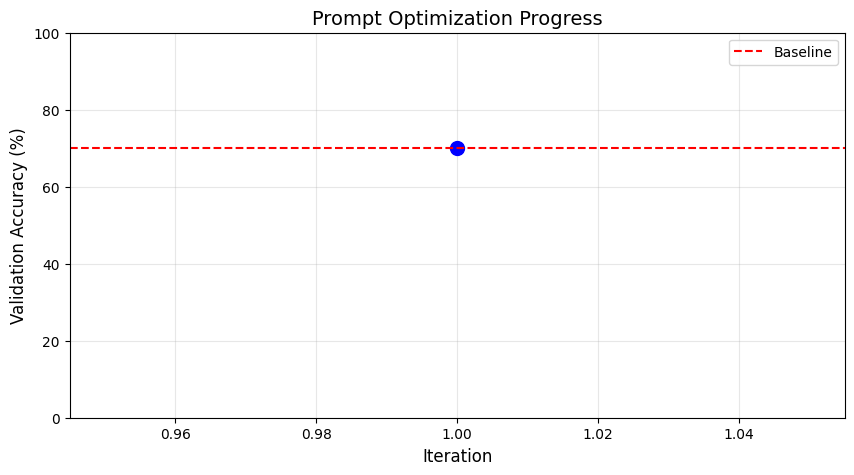

In [28]:
# Visualize optimization progress
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(optimization_result['accuracies']) + 1),
         [a * 100 for a in optimization_result['accuracies']],
         'bo-', linewidth=2, markersize=10)
plt.axhline(y=best_baseline_accuracy * 100, color='r', linestyle='--', label='Baseline')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Prompt Optimization Progress', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.show()


In [29]:
# Final evaluation on held-out test set
print("Final Evaluation on Test Set")
print("="*70)

# Baseline on test
baseline_test_acc, baseline_test_failures = evaluate_prompt(
    model, tokenizer, best_baseline_prompt, test_data
)
print(f"Baseline prompt: '{best_baseline_prompt}'")
print(f"Baseline test accuracy: {baseline_test_acc:.2%}")

print()

# Optimized on test
optimized_prompt = optimization_result['best_prompt']
optimized_test_acc, optimized_test_failures = evaluate_prompt(
    model, tokenizer, optimized_prompt, test_data
)
print(f"Optimized prompt: '{optimized_prompt}'")
print(f"Optimized test accuracy: {optimized_test_acc:.2%}")

print()
improvement = (optimized_test_acc - baseline_test_acc) * 100
print(f"Improvement: {improvement:+.1f} percentage points")


Final Evaluation on Test Set
Baseline prompt: '{question} answer'
Baseline test accuracy: 75.00%

Optimized prompt: '{question} answer'
Optimized test accuracy: 75.00%

Improvement: +0.0 percentage points


In [30]:
# Answer Checkpoint: Task 2.3 - Optimization Loop
print("="*70)
print("VALIDATING: optimize_prompt function")
print("="*70)

checks_passed = 0
checks_failed = 0

try:
    if 'optimization_result' in globals():
        result = optimization_result

        # Check 1: Returns a dictionary
        if isinstance(result, dict):
            print("✓ PASS: Function returns a dictionary")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Function should return dict, got {type(result)}")
            checks_failed += 1

        # Check 2: Has required keys
        required_keys = ['iterations', 'prompts', 'accuracies', 'best_prompt', 'best_accuracy']
        missing_keys = [k for k in required_keys if k not in result]
        if len(missing_keys) == 0:
            print("✓ PASS: History dictionary has all required keys")
            checks_passed += 1
        else:
            print(f"✗ FAIL: Missing keys: {missing_keys}")
            checks_failed += 1

        # Check 3: At least 1 iteration completed
        if len(result.get('iterations', [])) >= 1:
            print(f"✓ PASS: At least 1 iteration completed ({len(result['iterations'])} iterations)")
            checks_passed += 1
        else:
            print("✗ FAIL: Should complete at least 1 iteration")
            checks_failed += 1

        # Check 4: Prompts list contains initial prompt
        if len(result.get('prompts', [])) >= 1:
            print("✓ PASS: Prompts list contains at least initial prompt")
            checks_passed += 1
        else:
            print("✗ FAIL: Prompts list should contain at least initial prompt")
            checks_failed += 1

        # Check 5: Best accuracy is valid
        best_acc = result.get('best_accuracy', -1)
        if isinstance(best_acc, (int, float)) and 0.0 <= best_acc <= 1.0:
            print(f"✓ PASS: Best accuracy is valid: {best_acc:.2%}")
            checks_passed += 1
            # Check if improved (or at least maintained)
            if 'best_baseline_accuracy' in globals():
                if best_acc >= best_baseline_accuracy:
                    print(f"✓ PASS: Best accuracy ({best_acc:.2%}) >= baseline ({best_baseline_accuracy:.2%})")
                    checks_passed += 1
                else:
                    print(f"⚠ INFO: Best accuracy ({best_acc:.2%}) < baseline ({best_baseline_accuracy:.2%})")
                    print("   This is okay - optimization doesn't always improve immediately")
        else:
            print(f"✗ FAIL: best_accuracy should be between 0.0 and 1.0, got {best_acc}")
            checks_failed += 1

        # Check 6: Iterations structure
        if len(result.get('iterations', [])) > 0:
            first_iter = result['iterations'][0]
            iter_keys = ['prompt', 'train_accuracy', 'val_accuracy', 'n_failures']
            if all(k in first_iter for k in iter_keys):
                print("✓ PASS: Iteration data has correct structure")
                checks_passed += 1
            else:
                missing = [k for k in iter_keys if k not in first_iter]
                print(f"⚠ WARNING: Iteration data missing keys: {missing}")
    else:
        print("⚠ SKIP: optimization_result not found. Run the optimization loop cell first.")
except Exception as e:
    print(f"✗ FAIL: Error testing optimize_prompt: {e}")
    import traceback
    traceback.print_exc()
    checks_failed += 1

print("\n" + "="*70)
if checks_failed == 0:
    print(f"All checks passed! ✓ ({checks_passed} checks)")
else:
    print(f"Some checks failed: {checks_passed} passed, {checks_failed} failed")
print("="*70)


VALIDATING: optimize_prompt function
✓ PASS: Function returns a dictionary
✓ PASS: History dictionary has all required keys
✓ PASS: At least 1 iteration completed (1 iterations)
✓ PASS: Prompts list contains at least initial prompt
✓ PASS: Best accuracy is valid: 70.00%
✓ PASS: Best accuracy (70.00%) >= baseline (70.00%)
✓ PASS: Iteration data has correct structure

All checks passed! ✓ (7 checks)


---

## TASK 3: Interpretability Analysis (6 points)

Now we'll analyze *why* the optimized prompt performs better using white-box techniques.

**3.1**: *Confidence Analysis* — Compare model confidence (logit values) between prompts  
**3.2**: *Attention Analysis* — Visualize and compare attention patterns


### Task 3.1: Confidence Analysis

Compare how "confident" the model is when using the baseline vs optimized prompt:
1. Extract logits for the generated answer tokens
2. Convert to probabilities
3. Compare the probability assigned to correct tokens


In [35]:
def analyze_confidence(
    model,
    tokenizer,
    prompt_template: str,
    question: str,
    target_answer: str
) -> Dict:
    """
    Analyze model confidence for a given prompt and question.

    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt_template: The prompt template to use
        question: The question to answer
        target_answer: The correct answer

    Returns:
        Dictionary with confidence metrics
    """
    ## YOUR_CODE_STARTS_HERE
    prompt = prompt_template.format(question=question)

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    input_len = inputs["input_ids"].shape[1]

    pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id

    # Generate with logits
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=False,
            pad_token_id=pad_token_id,
            output_logits=True,
            return_dict_in_generate=True
        )

    # Extract first-step logits
    first_step_logits = outputs.logits[0][0]  # (vocab_size,)
    probs = F.softmax(first_step_logits, dim=-1)

    target_ids = tokenizer(
        target_answer, add_special_tokens=False
    )["input_ids"]

    # First token confidence
    if target_ids:
        first_token_id = target_ids[0]
        first_token_confidence = probs[first_token_id].item()
    else:
        first_token_confidence = 0.0

    # Entropy of distribution
    entropy = -torch.sum(probs * torch.log(probs + 1e-12)).item()

    # Decode generated text (optional but useful)
    gen_ids = outputs.sequences[:, input_len:]
    generated_text = tokenizer.decode(
        gen_ids[0], skip_special_tokens=True
    ).strip()

    return {
        "generated_text": generated_text,
        "first_token_confidence": first_token_confidence,
        "entropy": entropy
    }
    ## YOUR_CODE_ENDS_HERE


In [36]:
# Compare confidence between baseline and optimized prompts
print("Confidence Analysis: Baseline vs Optimized Prompt")
print("="*70)

# Select examples to analyze
analysis_examples = test_data[:10]

baseline_confidences = []
optimized_confidences = []
baseline_entropies = []
optimized_entropies = []

for example in analysis_examples:
    question = example['question']
    target = example['answer']

    # Analyze with baseline prompt
    baseline_result = analyze_confidence(model, tokenizer, best_baseline_prompt, question, target)
    baseline_confidences.append(baseline_result['first_token_confidence'])
    baseline_entropies.append(baseline_result['entropy'])

    # Analyze with optimized prompt
    optimized_result = analyze_confidence(model, tokenizer, optimized_prompt, question, target)
    optimized_confidences.append(optimized_result['first_token_confidence'])
    optimized_entropies.append(optimized_result['entropy'])

print(f"Average First Token Confidence:")
print(f"  Baseline:  {np.mean(baseline_confidences):.4f}")
print(f"  Optimized: {np.mean(optimized_confidences):.4f}")
print()
print(f"Average Entropy (lower = more confident):")
print(f"  Baseline:  {np.mean(baseline_entropies):.4f}")
print(f"  Optimized: {np.mean(optimized_entropies):.4f}")


Confidence Analysis: Baseline vs Optimized Prompt
Average First Token Confidence:
  Baseline:  0.0000
  Optimized: 0.0000

Average Entropy (lower = more confident):
  Baseline:  1.4999
  Optimized: 1.4999


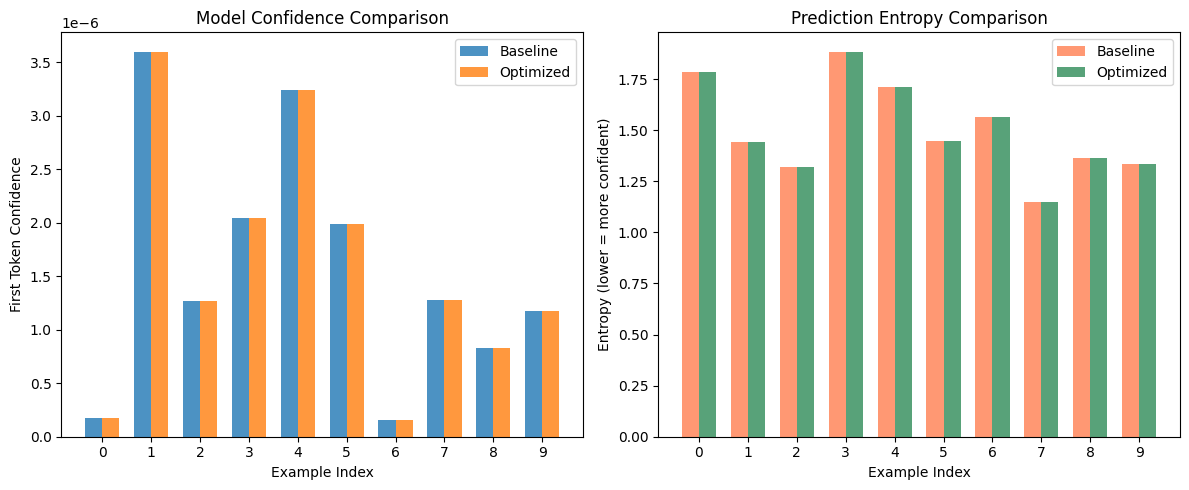

In [37]:
# Visualize confidence comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confidence bar chart
ax1 = axes[0]
x = np.arange(len(analysis_examples))
width = 0.35
ax1.bar(x - width/2, baseline_confidences, width, label='Baseline', alpha=0.8)
ax1.bar(x + width/2, optimized_confidences, width, label='Optimized', alpha=0.8)
ax1.set_xlabel('Example Index')
ax1.set_ylabel('First Token Confidence')
ax1.set_title('Model Confidence Comparison')
ax1.legend()
ax1.set_xticks(x)

# Entropy comparison
ax2 = axes[1]
ax2.bar(x - width/2, baseline_entropies, width, label='Baseline', alpha=0.8, color='coral')
ax2.bar(x + width/2, optimized_entropies, width, label='Optimized', alpha=0.8, color='seagreen')
ax2.set_xlabel('Example Index')
ax2.set_ylabel('Entropy (lower = more confident)')
ax2.set_title('Prediction Entropy Comparison')
ax2.legend()
ax2.set_xticks(x)

plt.tight_layout()
plt.show()


### Task 3.2: Attention Analysis

Visualize attention patterns to understand what the model "looks at" with different prompts:
1. Extract attention weights from the model (decoder attention for decoder-only models)
2. Create attention heatmaps
3. Compare attention concentration between prompts


In [38]:
def get_encoder_attention(
    model,
    tokenizer,
    prompt_template: str,
    question: str
) -> Tuple[torch.Tensor, List[str]]:
    """
    Extract attention weights for analysis (decoder attention for decoder-only models).

    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt_template: The prompt template
        question: The question

    Returns:
        Tuple of (attention_weights, token_labels)
        attention_weights: Tensor of shape (n_layers, n_heads, seq_len, seq_len)
        token_labels: List of token strings for labeling
    """
    ## YOUR_CODE_STARTS_HERE
    prompt = prompt_template.format(question=question)

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    input_ids = inputs["input_ids"][0]
    token_labels = tokenizer.convert_ids_to_tokens(input_ids)

    with torch.no_grad():
        outputs = model(
            **inputs,
            output_attentions=True,
            use_cache=False
        )

    # outputs.attentions is a tuple: one tensor per layer
    # Each tensor shape: (batch, n_heads, seq_len, seq_len)
    attentions = torch.stack(
        [layer_attn[0] for layer_attn in outputs.attentions]
    )
    # Final shape: (n_layers, n_heads, seq_len, seq_len)

    return attentions, token_labels
    ## YOUR_CODE_ENDS_HERE


In [39]:
def visualize_attention(
    attention: torch.Tensor,
    tokens: List[str],
    layer: int = -1,
    head: int = 0,
    title: str = "Attention Heatmap"
):
    """
    Visualize attention weights as a heatmap.

    Args:
        attention: Tensor of shape (n_layers, n_heads, seq_len, seq_len)
        tokens: List of token strings
        layer: Which layer to visualize (-1 for last)
        head: Which attention head to visualize
        title: Plot title
    """
    ## YOUR_CODE_STARTS_HERE
    if layer < 0:
        layer = attention.shape[0] + layer

    # Extract attention for chosen layer and head
    # Shape: (seq_len, seq_len)
    attn_matrix = attention[layer, head].detach().cpu().numpy()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attn_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis"
    )

    plt.title(f"{title} (Layer {layer}, Head {head})")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    ## YOUR_CODE_ENDS_HERE


Analyzing attention for question:
  Tom has 90 candies. He wants to share them equally among 10 friends. How many candies does each friend get?
  Answer: 9

Baseline prompt: '{question} answer'


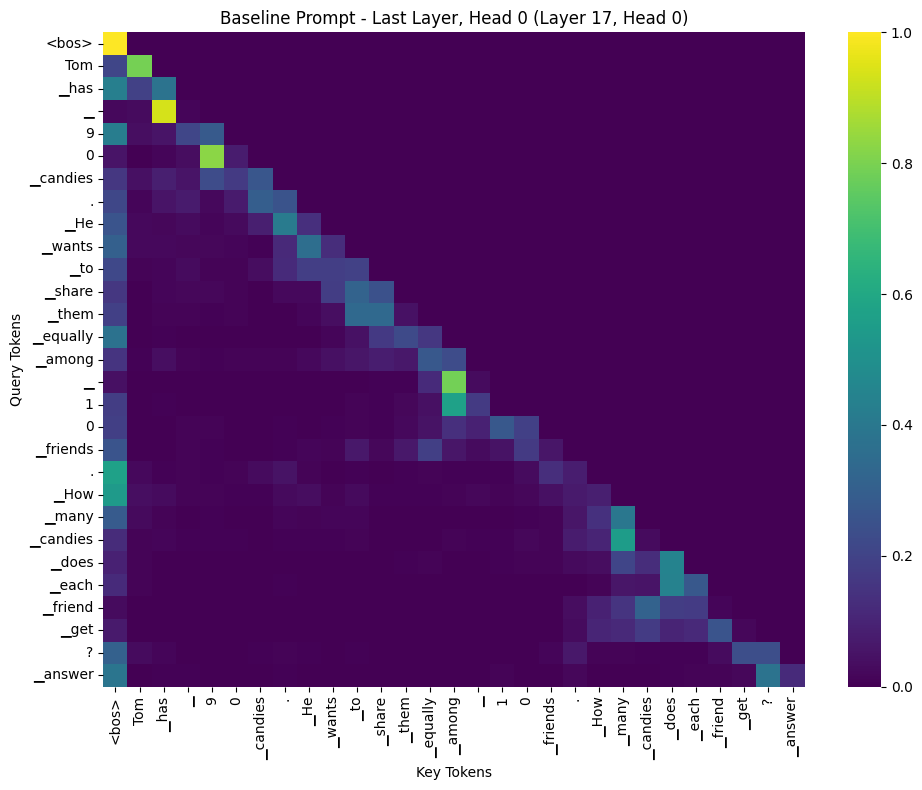

Optimized prompt: '{question} answer'


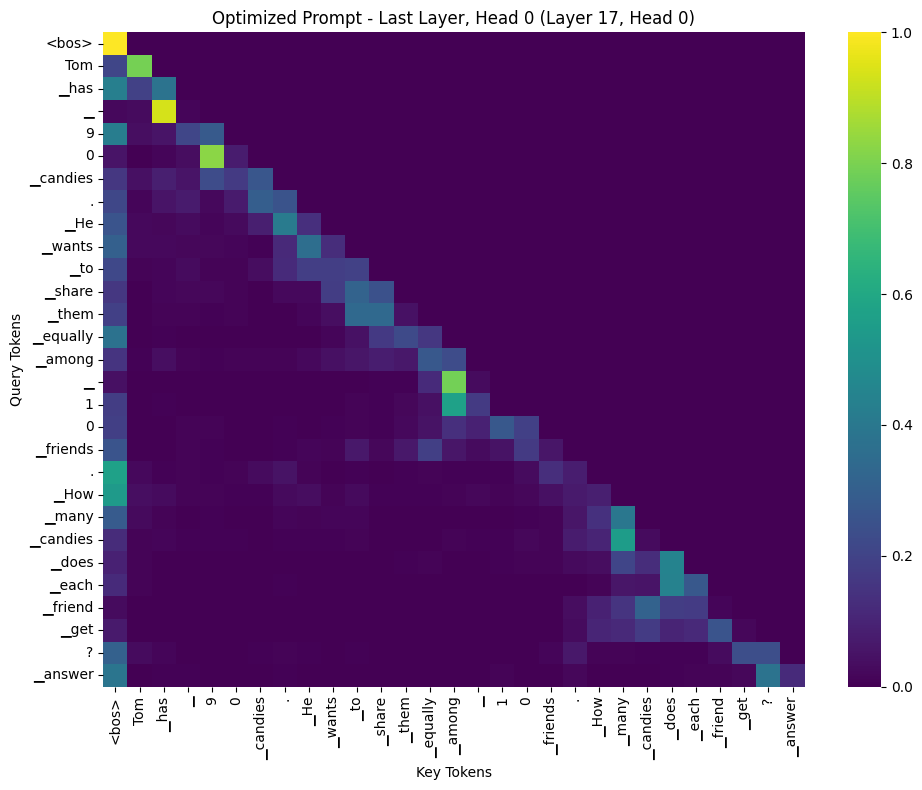

In [40]:
# Compare attention patterns for a specific example
example = test_data[0]
print(f"Analyzing attention for question:")
print(f"  {example['question']}")
print(f"  Answer: {example['answer']}")
print()

# Get attention for baseline prompt
baseline_attn, baseline_tokens = get_encoder_attention(
    model, tokenizer, best_baseline_prompt, example['question']
)
print(f"Baseline prompt: '{best_baseline_prompt}'")
visualize_attention(
    baseline_attn, baseline_tokens,
    layer=-1, head=0,
    title="Baseline Prompt - Last Layer, Head 0"
)

# Get attention for optimized prompt
optimized_attn, optimized_tokens = get_encoder_attention(
    model, tokenizer, optimized_prompt, example['question']
)
print(f"Optimized prompt: '{optimized_prompt}'")
visualize_attention(
    optimized_attn, optimized_tokens,
    layer=-1, head=0,
    title="Optimized Prompt - Last Layer, Head 0"
)


In [43]:
def compute_attention_concentration(
    attention: torch.Tensor,
    tokens: List[str],
    number_pattern: str = r'\d+'
) -> Dict:
    """
    Compute how much attention is concentrated on number tokens.

    Args:
        attention: Attention tensor (layers, heads, seq, seq)
        tokens: List of token strings
        number_pattern: Regex pattern for number tokens

    Returns:
        Dictionary with attention concentration metrics
    """
    ## YOUR_CODE_STARTS_HERE
    number_indices = [
        i for i, tok in enumerate(tokens)
        if re.search(number_pattern, tok)
    ]

    if not number_indices:
        return {
            "avg_attention_per_number": 0.0,
            "number_attention_ratio": 0.0,
            "num_number_tokens": 0
        }

    # attention shape: (layers, heads, seq, seq)
    # Average over layers and heads
    avg_attention = attention.mean(dim=(0, 1))  # (seq, seq)

    # Normalize attention so total mass = 1
    avg_attention = avg_attention / avg_attention.sum()

    # Attention paid TO number tokens (columns = keys)
    number_attention = avg_attention[:, number_indices].sum().item()

    avg_attention_per_number = number_attention / len(number_indices)

    return {
        "avg_attention_per_number": avg_attention_per_number,
        "number_attention_ratio": number_attention,
        "num_number_tokens": len(number_indices)
    }
    ## YOUR_CODE_ENDS_HERE


Attention Concentration Analysis
Measuring how much attention is directed toward number tokens...

Average Attention per Number Token:
  Baseline:  0.0169
  Optimized: 0.0169



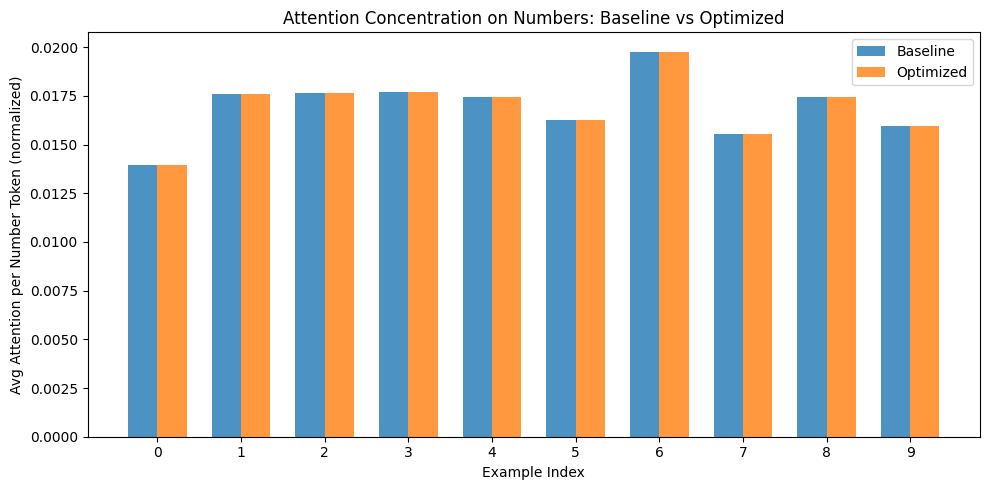

In [44]:
# Compare attention concentration across multiple examples
print("Attention Concentration Analysis")
print("="*70)
print("Measuring how much attention is directed toward number tokens...\n")

baseline_number_attention = []
optimized_number_attention = []

for i, example in enumerate(test_data[:10]):
    # Baseline
    b_attn, b_tokens = get_encoder_attention(model, tokenizer, best_baseline_prompt, example['question'])
    b_conc = compute_attention_concentration(b_attn, b_tokens)
    baseline_number_attention.append(b_conc['avg_attention_per_number'])
    # Optimized
    o_attn, o_tokens = get_encoder_attention(model, tokenizer, optimized_prompt, example['question'])
    o_conc = compute_attention_concentration(o_attn, o_tokens)
    optimized_number_attention.append(o_conc['avg_attention_per_number'])
print(f"Average Attention per Number Token:")
print(f"  Baseline:  {np.mean(baseline_number_attention):.4f}")
print(f"  Optimized: {np.mean(optimized_number_attention):.4f}")
print()

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(10)
width = 0.35
ax.bar(x - width/2, baseline_number_attention, width, label='Baseline', alpha=0.8)
ax.bar(x + width/2, optimized_number_attention, width, label='Optimized', alpha=0.8)
ax.set_xlabel('Example Index')
ax.set_ylabel('Avg Attention per Number Token (normalized)')
ax.set_title('Attention Concentration on Numbers: Baseline vs Optimized')
ax.legend()
ax.set_xticks(x)
plt.tight_layout()
plt.show()


---

## Summary and Analysis

Write your analysis of why the optimized prompt performed better based on the interpretability findings.


### Your Analysis (Fill this in)

**1. Prompt Optimization Results:**
- Initial baseline prompt: [YOUR ANSWER]
- Final optimized prompt: [YOUR ANSWER]
- Accuracy improvement: [YOUR ANSWER]

**2. Confidence Analysis Findings:**
- How did model confidence change with the optimized prompt?
- What does the entropy comparison tell us?

[YOUR ANSWER]

**3. Attention Analysis Findings:**
- Did the optimized prompt change what the model attends to?
- Was there more attention on important tokens (numbers)?

[YOUR ANSWER]

**4. Why Did Optimization Work?**
- Based on your analysis, explain why the optimized prompt performs better.

[YOUR ANSWER]

**5. Limitations:**
- What are the limitations of this approach?
- When might automatic prompt optimization fail?

[YOUR ANSWER]


In [ ]:
# Final summary statistics
print("="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nBaseline Prompt: '{best_baseline_prompt}'")
print(f"Optimized Prompt: '{optimized_prompt}'")
print(f"\nTest Set Performance:")
print(f"  Baseline Accuracy:  {baseline_test_acc:.2%}")
print(f"  Optimized Accuracy: {optimized_test_acc:.2%}")
print(f"  Improvement: {(optimized_test_acc - baseline_test_acc)*100:+.1f}%")
print(f"\nInterpretability Metrics (averaged over test examples):")
print(f"  Confidence - Baseline:  {np.mean(baseline_confidences):.4f}")
print(f"  Confidence - Optimized: {np.mean(optimized_confidences):.4f}")
print(f"  Avg Attention per Number Token - Baseline:  {np.mean(baseline_number_attention):.4f}")
print(f"  Avg Attention per Number Token - Optimized: {np.mean(optimized_number_attention):.4f}")

# BONUS (2 points): Solve any task with an LLM

**Goal.**  
Pick **one** of the homework tasks (Task 1, Task 2, or Task 3) and solve it using an **LLM**. Provide the **LLM** with the **task description** and any **starter/prerequisite code** it depends on, ask it to generate a complete **code solution** first, then run that **generated code** here in the code notebook yourself. Finally, document what you did and **compare** the LLM’s result to your own pipeline.

**What to deliver below.**
1) **LLM used** (name + version, e.g., “Llama-3-8B-Instruct”, “GPT-x”, “Claude-x”, “Mistral-x”, etc.).  
2) **Prompt(s)** you used.  
3) **LLM output** — copy and paste the generated code.  
4) **Comparison** to your solution: what matches or differs (quantitative or qualitative).  
5) **Reflection**: what the LLM was **good at** vs **bad at**, what it got **right** vs **wrong**.

> **No code required.** You do **not** need to run, share, or submit any code used for the LLM generation. Provide only the deliverables listed above.
> You may use any LLMs through any interface (API, web UI, local inference).
